# Monte Carlo Simulation for FE
## IEOR 4703
## Assignment 4

# Charles Laferte - cl4249

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from BMS import BMS_price
from time import time
import statistics
# import our polynomial function
from polynomials import constructX
# linear regression
from sklearn.linear_model import LinearRegression

## Problem 1 (pricing American via Simulation):

Use the sample code american via fd.ipynb to extract the exercise boundary for American put for the following parameters: spot price of S0 = 100, strike price K = 80, risk-free rate r = 0.025, continuous divided rate of q = 0.05, volatility of σ = 0.30, maturity of T = 2 years. Use the extracted exercise boundary to price the same American put option via simulation using the sample code american via simulation given boundary.ipynb. Use 20,000, 50,000, and 100,000 simulated paths and compare the results.

Tridiagonal solver

In [5]:
def tridiag_solver(l, d, u, b):
    n = len(b)
    D = np.copy(d)
    B = np.copy(b)
    x = np.zeros(n)
    for i in range(1, n):
        w = l[i] / D[i-1]
        D[i] = D[i] - w*u[i-1]
        B[i] = B[i] - w*B[i-1]
    x[n-1] = B[n-1]/D[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (B[i] - u[i]*x[i+1])/D[i]
    return x

Parameters for the pricing

In [3]:
r = 0.025
q = 0.05
    
S = 100
K = 80
sig = 0.3
T = 2

In [5]:
st = time()

# 0,1,2,...,N,N+1

# hyperparamters 
sMin = 10
sMax = 610

N = 4000
M = 365*2

dS = (sMax - sMin)/N
dT = T/M

s = np.zeros(N-1)
tau = np.zeros(M)

l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)

vCall = np.zeros(N-1)
vPut = np.zeros(N-1)

alpha = 0.5*sig**2*dT/dS**2
beta = (r - q)*dT/(2.0*dS)

for i1 in range(N-1):
    
    s[i1] = sMin + (i1 + 1)*dS
    if i1 == 0: 
        d[i1]= 1 + r*dT + 2*beta*s[i1]
        u[i1] = -2*beta*s[i1]
    elif i1 == N-2: 
        l[i1] =  2*beta*s[i1]
        d[i1] = 1 + r*dT - 2*beta*s[i1]
    else:
        l[i1] = -alpha*s[i1]**2 + beta*s[i1]
        d[i1] = 1 + r*dT + 2*alpha*s[i1]**2
        u[i1] = -alpha*s[i1]**2 - beta*s[i1]
        
    vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut[i1]  = np.maximum(K - s[i1], 0)
    
# exercise boundaries
SxCall = np.zeros((M,1))
SxPut = np.zeros((M,1))

for j1 in range(M):
    tau[j1] = (j1 + 1)*dT
    vCall = tridiag_solver(l, d, u, vCall)
    flagC = 0
    for i1 in range(N-2, -1, -1):
        # exercise boundary
        if flagC == 0 and vCall[i1] > np.maximum(s[i1] - K, 0):
            SxCall[j1] = s[i1]
            flagC = 1
        # premium
        if vCall[i1] <= np.maximum(s[i1] - K, 0):
            vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut = tridiag_solver(l, d, u, vPut)
    flagP = 0
    for i1 in range(0, N-1):
        # exercise boundary
        if flagP == 0 and vPut[i1] > np.maximum(K - s[i1], 0):
            SxPut[j1] = s[i1]
            flagP = 1
        # premium
        if vPut[i1] <= np.maximum(K - s[i1], 0):
            vPut[i1] = np.maximum(K - s[i1], 0)
            
et = time()
print('Elapsed time was %f seconds' % (et-st))



Elapsed time was 37.013127 seconds


Option prices

In [6]:
call_European = BMS_price('call', S, K, r, q, sig, T)
put_European = BMS_price('put', S, K, r, q, sig, T)

call_American = np.interp(S, s, vCall)
put_American = np.interp(S, s, vPut)

print('European call = %f' % call_European)
print('American call = %f' % call_American)
print('European put = %f' % put_European)
print('American put = %f' % put_American)

European call = 22.313911
American call = 24.094836
European put = 7.928523
American put = 7.929424


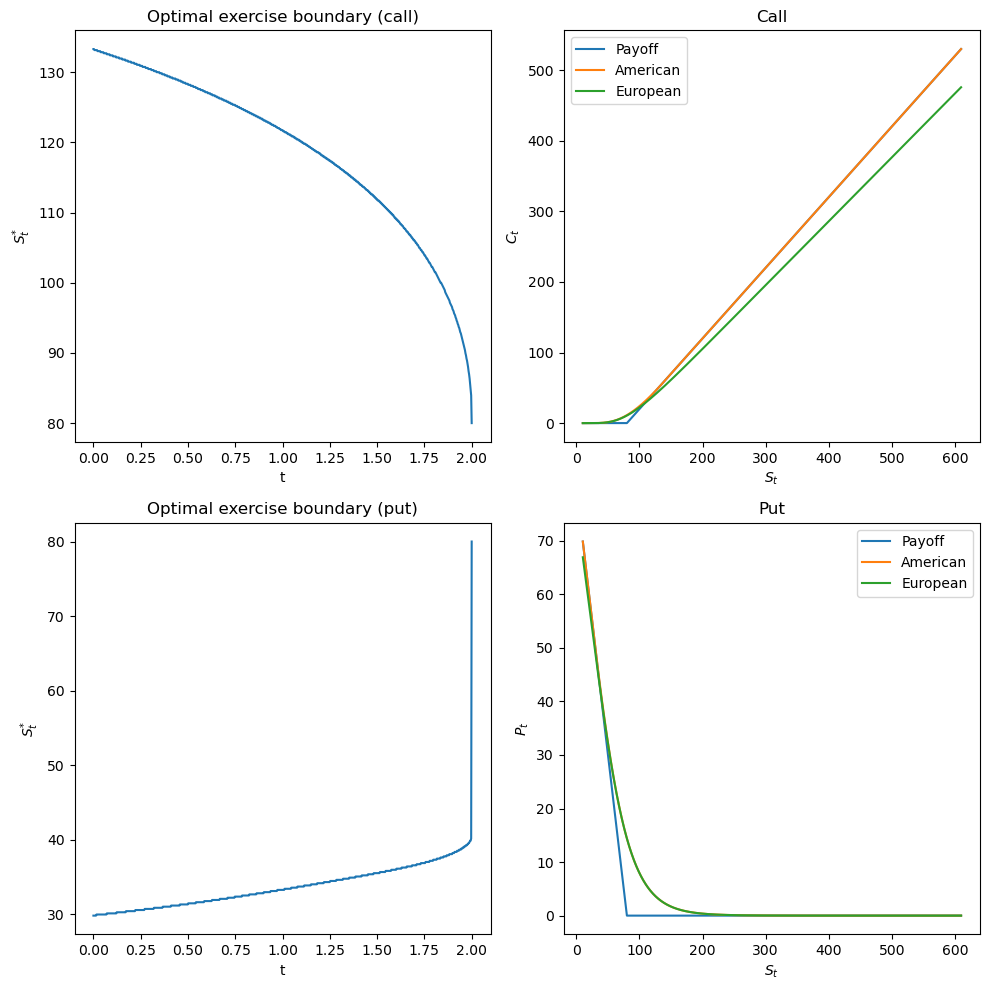

In [7]:
eCall = BMS_price('call', s, K, r, q, sig, T)
ePut = BMS_price('put', s, K, r, q, sig, T)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
# calendar time
tmp = np.append(K,SxCall)
tmp = tmp.reshape(M+1, 1)
#tmp = np.sort(tmp)
tmp = tmp[::-1]
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (call)')
plt.tight_layout()
 
exerciseBoundary_file = open("exerciseBoundaryCall.dat", "w")
for eb in tmp:
    np.savetxt(exerciseBoundary_file, eb)
exerciseBoundary_file.close()

plt.subplot(2, 2, 2)
plt.plot(s, np.maximum(s - K,0))
plt.plot(s, vCall)
plt.plot(s, eCall);
plt.xlabel('$S_t$')
plt.ylabel('$C_t$')
plt.title('Call')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.subplot(2, 2, 3)
# calendar time
tmp = np.append(K,SxPut)
tmp = tmp.reshape(M+1, 1)
#tmp = np.sort(tmp)
tmp = tmp[::-1]
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (put)')
plt.tight_layout()

exerciseBoundary_file = open("exerciseBoundaryPut.dat", "w")
tmp.reshape(M+1, 1)
for eb in tmp:
    np.savetxt(exerciseBoundary_file, eb)
exerciseBoundary_file.close()

plt.subplot(2, 2, 4)
plt.plot(s, np.maximum(K - s,0))
plt.plot(s, vPut)
plt.plot(s, ePut);
plt.xlabel('$S_t$')
plt.ylabel('$P_t$')
plt.title('Put')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.show()

Here, we pushed the excercise boundary for the American put in the file 'exerciseBoundaryPut.dat'. Let's retrieve it.

In [8]:
exerciseBoundary = np.loadtxt('exerciseBoundaryPut.dat')

####  Simulation with 20,000, 50,000 and 100,000 simulated paths

In [9]:
np.random.seed(456718)

list_numPaths = [20000, 50000, 100000]

for numPaths in list_numPaths:
    m = 365*2
    tau = T
    s0 = S
    dt = tau/m
    s = np.zeros((m+1, numPaths))
    t = np.linspace(0, 1, m+1) * tau

    payoffs       = np.zeros(numPaths)
    payoffs_early = np.zeros(numPaths)
    indicators    = np.zeros(numPaths, dtype=int)

    europeanPremium = BMS_price('put', s0, K, r, q, sig, tau)
    st = time()
    
    for j in range(numPaths):  

        s[0,j]  = s0 
        T = tau 

        # reset the flag
        flag = 0

        for i in range(1, m+1):
            z = np.random.randn()    
            s[i,j] = s[i-1,j] * np.exp( (r-q-sig*sig/2)*dt + sig*np.sqrt(dt)*z )

            #print(i,exerciseBoundary[i])

            if flag == 0 and s[i,j] < exerciseBoundary[i]:

                # exercise & discount according to the time of exercise
                # payoffs_early[j] = np.exp(-r*tau)*(K - s[i,j])
                payoffs_early[j] = np.exp(-r*i*dt)*(K - s[i,j])

                # turn the flag on
                flag = 1 

            if i == m:
                payoffs[j] = np.exp(-r*tau) * np.maximum(K - s[i,j], 0)

        if flag == 0:
            payoffs_early[j] = payoffs[j]
            indicators[j] = 1


    et = time()
    print(60*'=')
    print('Number of simulations: %i' % numPaths)
    print('Elapsed time was %f seconds.' % (et-st))

    # simulation output
    european = np.mean(payoffs)
    american = np.mean(payoffs_early)

    print('European price (BSM): %f' % europeanPremium)
    print('European price (Sim): %f' % european)
    print('American price (Sim): %f' % american)
    print(60*'=')

Number of simulations: 20000
Elapsed time was 64.128799 seconds.
European price (BSM): 7.928523
European price (Sim): 8.009484
American price (Sim): 8.003774
Number of simulations: 50000
Elapsed time was 165.089653 seconds.
European price (BSM): 7.928523
European price (Sim): 7.934302
American price (Sim): 7.935414
Number of simulations: 100000
Elapsed time was 342.145750 seconds.
European price (BSM): 7.928523
European price (Sim): 8.014683
American price (Sim): 8.015276


#### Comparaison of the results for the 3 simulations

We can see the computations take longer with higher numbers of path gsimulated which is logical. We manage to get closer to the real value obtained by FD method by increasing the number of paths but it steems to converge slowy while increasing this parameter.

## Problem 2 (Pricing No-touch Rebate):

Assume spot price of S0 = 1, 000, risk-free rate r = 0.05, continuous divided rate of q = 0.0185, volatility of σ = 0.30, and maturity of T = 2 years. Consider the following two barriers: low barrier of $\$700$ and high barrier of $\$1, 300$. The holder of this option would recieve a rebate of $100 if the stock does not hit or cross the barriers at any time during the life of the option. Estimate the price of this contract via simulation.

In [10]:
S0 = 1000
r = 0.05
q = 0.0185
sig = 0.3
T = 2


In [11]:
nb_paths = 50000
N = 500

upper_bound = 1300
lower_bound = 700

rebate = 100

In [12]:
dt = T/N
P = []
for i in range(nb_paths):
    s=[S0]
    for i in range(N):
        # Generating next value of the underlying St
        z1 = np.random.randn()
        st = s[-1]* np.exp((r - q -sig*sig/2)*(dt) + sig*np.sqrt(dt)*z1)
        s.append(st)
        if st>upper_bound:
            p = 0
            break
        elif st<lower_bound:
            p = 0
            break
        else: 
            p=rebate

    P.append(np.exp(-r*T)*p)
    
mean_price = sum(P)/nb_paths
var_price = statistics.variance(P)
print('Price of the contract obtained via simulation: ', mean_price)
z_a = 1.96
cf_interval = [mean_price-z_a*np.sqrt(var_price/nb_paths), mean_price+z_a*np.sqrt(var_price/nb_paths)]
print('Confidence interval (5% level): ', cf_interval)


Price of the contract obtained via simulation:  13.105665162832853
Confidence interval (5% level):  [12.826530409370665, 13.38479991629504]


## Problem 3 (Pricing American via Simulation):

The code american via simulation extracting exercise boundary.ipynb can be utilized for pricing an American put option. Use the code to price American option under the parameter set provided in the sample code for the different cases.

In [3]:
r = 0.10
q = 0.01
s0 = 100
K = 100
sig = 0.40
T = 1
m = 365 
dt = T/m
#indicators = np.zeros(numPaths)

In [8]:
# hyperparamters
sMin = 10
sMax = 610
N = 4000
M = 365
dS = (sMax - sMin)/N
dT = T/M
s = np.zeros(N-1)
tau = np.zeros(M)
l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)
vCall = np.zeros(N-1)
vPut = np.zeros(N-1)
alpha = 0.5*sig**2*dT/dS**2
beta = (r - q)*dT/(2.0*dS)
st = time()

for i1 in range(N-1):
    
    s[i1] = sMin + (i1 + 1)*dS
    if i1 == 0: 
        d[i1]= 1 + r*dT + 2*beta*s[i1]
        u[i1] = -2*beta*s[i1]
    elif i1 == N-2: 
        l[i1] =  2*beta*s[i1]
        d[i1] = 1 + r*dT - 2*beta*s[i1]
    else:
        l[i1] = -alpha*s[i1]**2 + beta*s[i1]
        d[i1] = 1 + r*dT + 2*alpha*s[i1]**2
        u[i1] = -alpha*s[i1]**2 - beta*s[i1]
        
    vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut[i1]  = np.maximum(K - s[i1], 0)
    
# exercise boundaries
SxCall = np.zeros((M,1))
SxPut = np.zeros((M,1))

for j1 in range(M):
    tau[j1] = (j1 + 1)*dT
    vCall = tridiag_solver(l, d, u, vCall)
    flagC = 0
    for i1 in range(N-2, -1, -1):
        # exercise boundary
        if flagC == 0 and vCall[i1] > np.maximum(s[i1] - K, 0):
            SxCall[j1] = s[i1]
            flagC = 1
        # premium
        if vCall[i1] <= np.maximum(s[i1] - K, 0):
            vCall[i1] = np.maximum(s[i1] - K, 0)
    vPut = tridiag_solver(l, d, u, vPut)
    flagP = 0
    for i1 in range(0, N-1):
        # exercise boundary
        if flagP == 0 and vPut[i1] > np.maximum(K - s[i1], 0):
            SxPut[j1] = s[i1]
            flagP = 1
        # premium
        if vPut[i1] <= np.maximum(K - s[i1], 0):
            vPut[i1] = np.maximum(K - s[i1], 0)
            
et = time()
print('Elapsed time was %f seconds' % (et-st))


Elapsed time was 13.047450 seconds


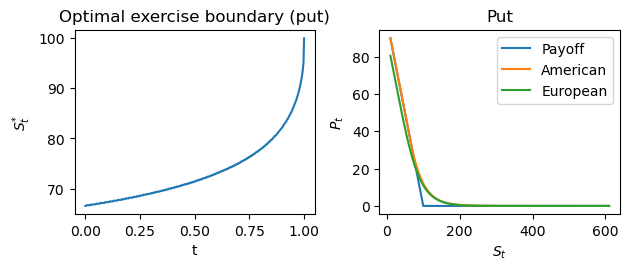

In [9]:
ePut = BMS_price('put', s, K, r, q, sig, T)

plt.subplot(2, 2, 3)
# calendar time
tmp = np.append(K,SxPut)
tmp = tmp.reshape(M+1, 1)
#tmp = np.sort(tmp)
tmp = tmp[::-1]
plt.plot(np.append(0, tau), tmp)
plt.xlabel('t')
plt.ylabel('$S^{*}_{t}$')
plt.title('Optimal exercise boundary (put)')
plt.tight_layout()

exerciseBoundary_file = open("exerciseBoundaryPut_ex3.dat", "w")
tmp.reshape(M+1, 1)
for eb in tmp:
    np.savetxt(exerciseBoundary_file, eb)
exerciseBoundary_file.close()

plt.subplot(2, 2, 4)
plt.plot(s, np.maximum(K - s,0))
plt.plot(s, vPut)
plt.plot(s, ePut);
plt.xlabel('$S_t$')
plt.ylabel('$P_t$')
plt.title('Put')
plt.legend(['Payoff', 'American', 'European'])
plt.tight_layout()

plt.show()

In [12]:
put_American = np.interp(s0, s, vPut)
print('American put = %f' % put_American)

American put = 12.191353


In [13]:
def polynomial_pricing(nb_of_basis, nb_of_paths,list_typeOfPolynomial):
    np.random.seed(4456129)
    
    numPaths = 50000

    sMin = 10
    sMax = 610

    # number of basis
    #d = 5
    r = 0.10
    q = 0.01
    s0 = 100
    K = 100
    sig = 0.40
    T = 1

    m = 365 # daily excercise
    numPaths = 50000

    dt = T/m
    #typeOfPolynomial = 'Chebychev_firstKind'
    question_mark = ["a","b","c"]
    i = 0
    
    for typeOfPolynomial in list_typeOfPolynomial:
        print(60*"=")
        print(question_mark[i])
        i+=1
        print(60*"=")
        for d in nb_of_basis:
            print(60*"=")
            print('Type of Polynomial: ', typeOfPolynomial)
            print('Number of basis: %i' %d)
            for numPaths in nb_of_paths:
                st = time()
                
                indicators = np.zeros(numPaths)
                #Initiate paths (not efficient; we should utilize the Brownian Bridge)
                # simulate stock prices
                s = np.zeros((m+1, numPaths))
                t = np.linspace(0, T, m+1)
                z = np.random.randn(m, numPaths)
                delta_log_s = (r - q - sig*sig/2)*dt + sig*np.sqrt(dt)*z
                log_s = np.zeros((m+1, numPaths))
                log_s[0,:] = np.log(s0)
                log_s[1:,:] = delta_log_s
                log_s = np.cumsum(log_s, 0)
                s = np.exp(log_s)

                P = np.maximum(K - s[m,:], 0)
                #print(np.exp(-r*T)*np.mean(P))
                vHat = np.zeros(numPaths)
                sArray = np.zeros(m+1)
                sArray[m] = K

                for i in np.arange(m-1, 0, -1):
                    s_i = s[i, :]
                    g = np.maximum(K - s_i, 0)
                    # in-the-money indicator
                    indicator = (g > 0)
                    xi = s_i[indicator]
                    if typeOfPolynomial == 'Laguerre':
                        xXi = constructX(xi, typeOfPolynomial, d)
                    elif typeOfPolynomial == 'Chebychev_firstKind' or typeOfPolynomial == 'Chebychev_secondKind':
                        # make it shifted from (-1,1) to (sMin, sMax)
                        xXi = constructX(2*(xi - sMin)/(sMax - sMin) - 1, typeOfPolynomial, d)
                    yi = np.exp(-r*dt)*P[indicator]
                    # regression
                    reg = LinearRegression(fit_intercept=False).fit(xXi, yi)
                    alpha = reg.coef_
                    vH = np.dot(xXi, alpha)
                    vHat[indicator] = vH

                    len1 = len(xi)
                    tmp = np.zeros((len1, 3))
                    tmp[:, 0] = xi
                    tmp[:, 1] = np.maximum(K - xi, 0)
                    tmp[:, 2] = vH
                    # sort tmp by xi
                    tmp = tmp[tmp[:,0].argsort()]
                    for j in np.arange(len1-1, -1, -1):
                        if tmp[j,2] <= tmp[j,1]:
                            sArray[i] = tmp[j,0]
                            #print('%i, %f' % (i+1, sArray[i]))
                            break

                    indx = np.logical_and(indicator, g > vHat)
                    P[indx] = g[indx]
                    P[~indx] = np.exp(-r*dt)*P[~indx]

                et = time()

                print(60*'-')
                print('Number of sims: %i' % numPaths)
                print('Elapsed times was %f seconds' % (et-st))
                premiumHat = np.exp(-r*dt) * np.mean(P)
                print('American price: %f' % premiumHat)

                
                # load the exercise boundary
                exerciseBoundary = np.loadtxt('exerciseBoundaryPut.dat')
                plt.figure()
                plt.plot(t, exerciseBoundary)
                plt.plot(t, sArray)
                plt.title('Optimal exercise boundary (put)')
                plt.xlabel(r'$\tau$')
                plt.ylabel('$S^*_t$')
                plt.show()
        
        
        

a
Type of Polynomial:  Chebychev_firstKind
Number of basis: 4
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 7.496074 seconds
American price: 12.183960


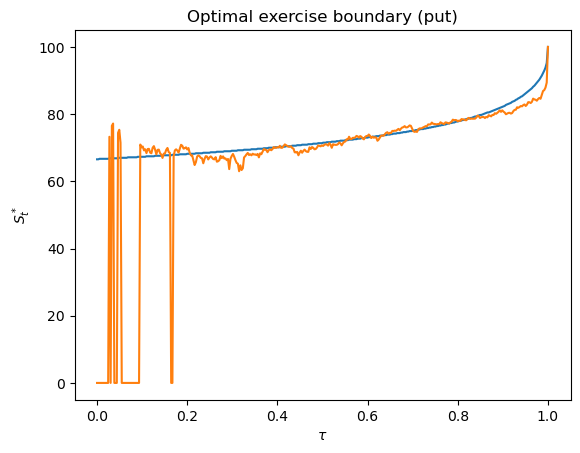

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 16.908436 seconds
American price: 12.233886


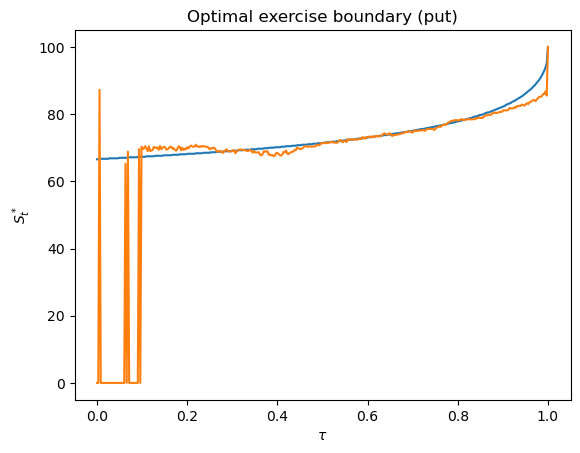

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 34.194615 seconds
American price: 12.147277


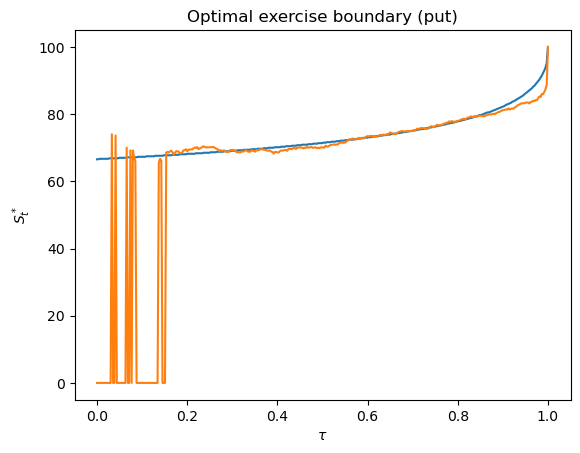

Type of Polynomial:  Chebychev_firstKind
Number of basis: 5
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 8.330539 seconds
American price: 12.420933


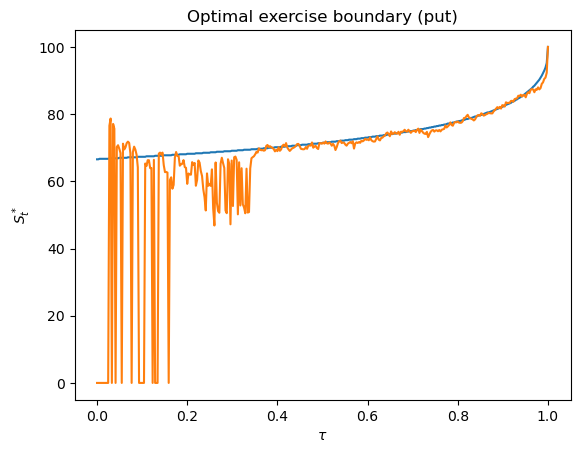

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 16.008800 seconds
American price: 12.231622


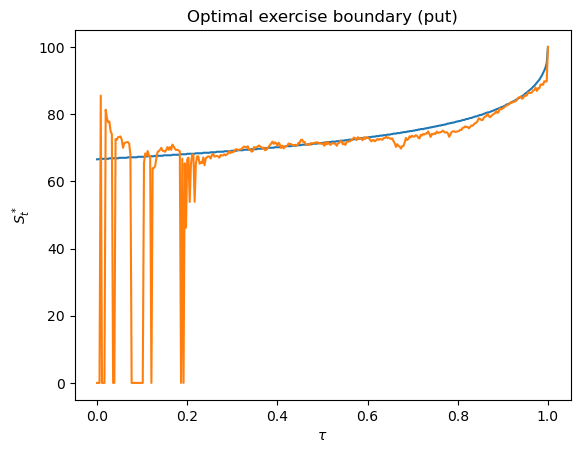

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 36.184536 seconds
American price: 12.164210


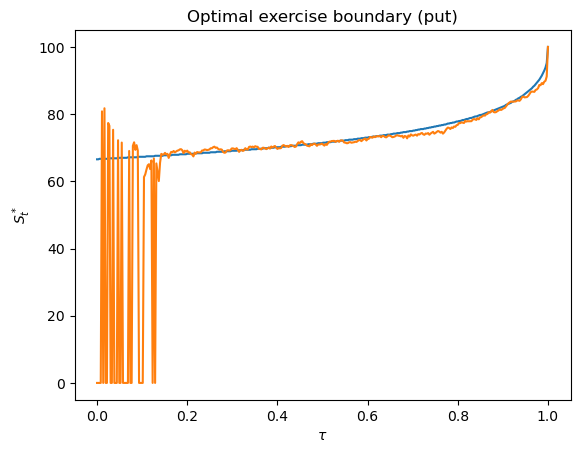

Type of Polynomial:  Chebychev_firstKind
Number of basis: 6
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 9.075354 seconds
American price: 12.266158


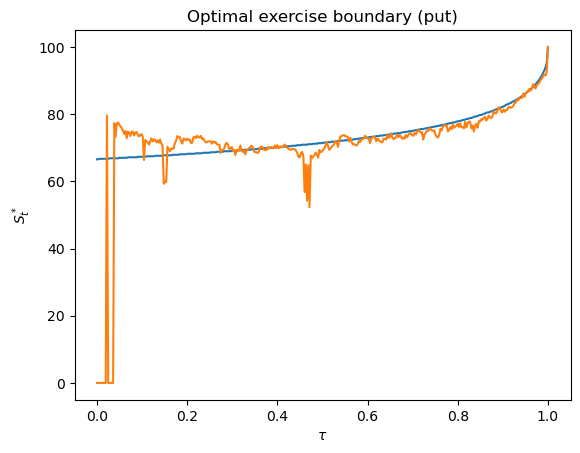

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 17.676682 seconds
American price: 12.286227


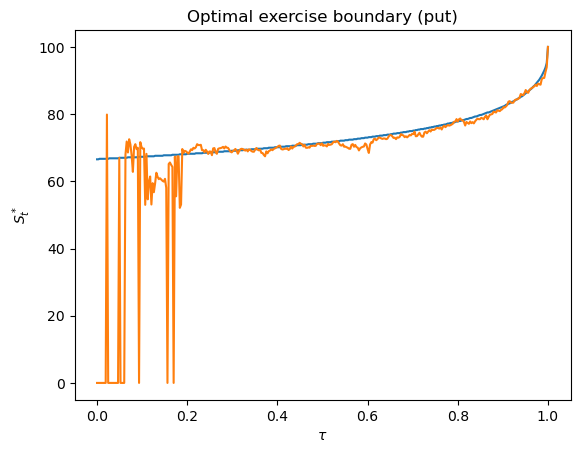

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 40.244254 seconds
American price: 12.181825


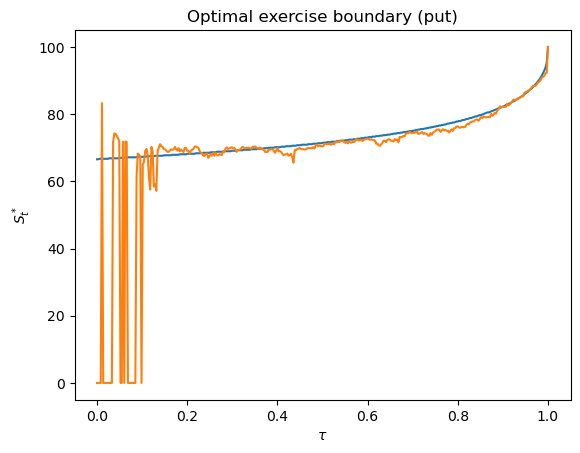

Type of Polynomial:  Chebychev_firstKind
Number of basis: 7
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 9.611267 seconds
American price: 12.188043


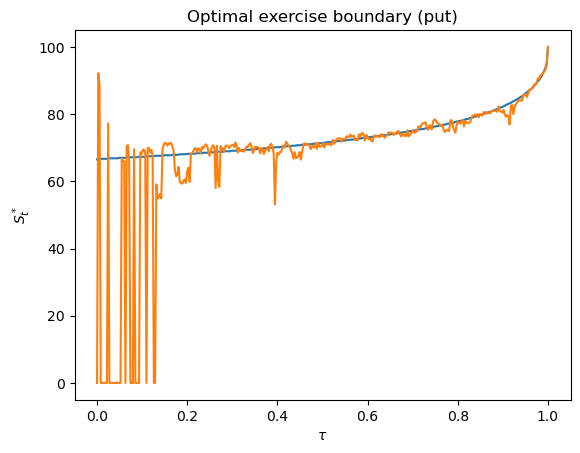

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 19.903913 seconds
American price: 12.138478


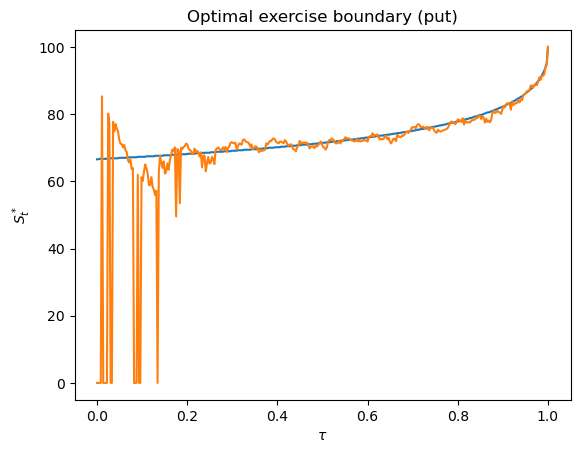

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 43.350285 seconds
American price: 12.207089


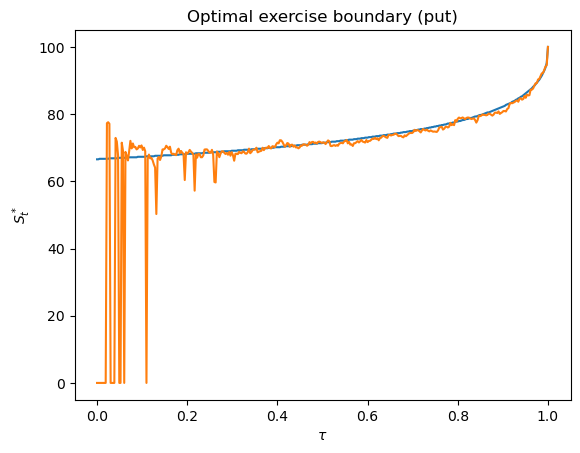

b
Type of Polynomial:  Chebychev_secondKind
Number of basis: 4
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 8.100476 seconds
American price: 12.194832


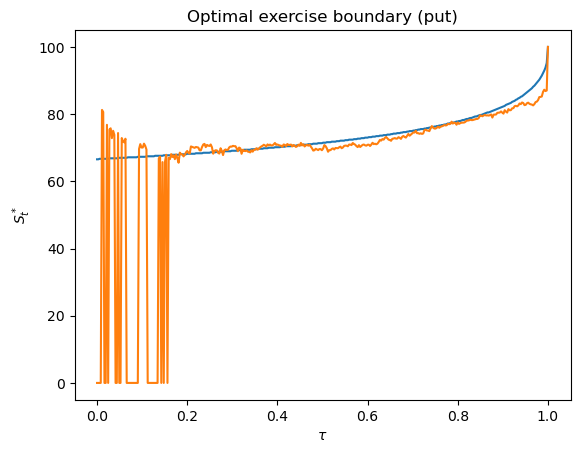

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 15.440678 seconds
American price: 12.159988


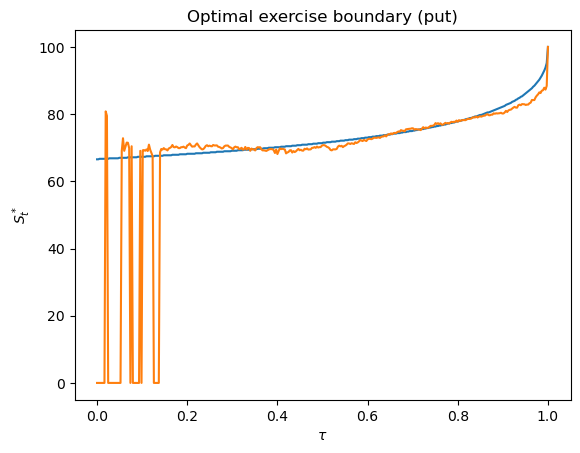

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 34.412135 seconds
American price: 12.192498


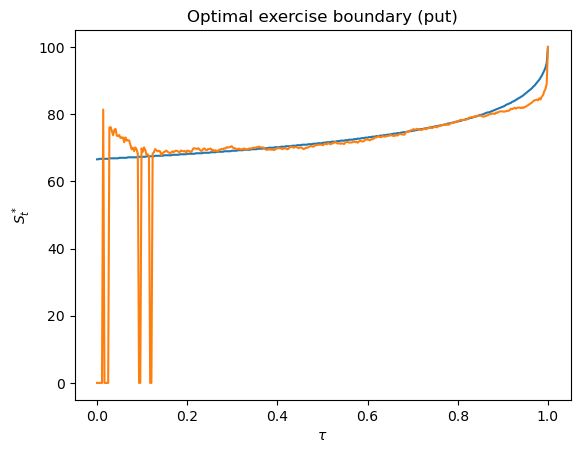

Type of Polynomial:  Chebychev_secondKind
Number of basis: 5
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 8.319451 seconds
American price: 12.183636


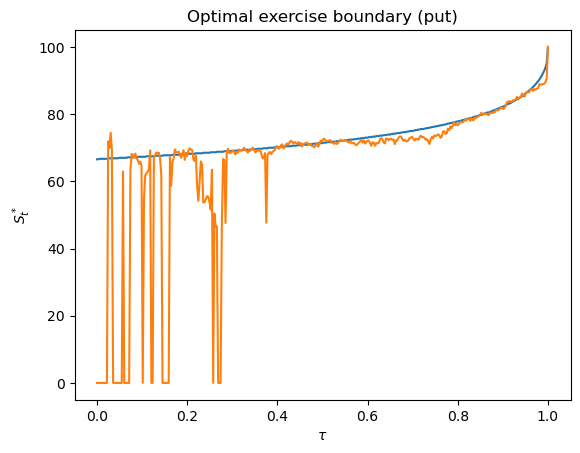

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 20.239217 seconds
American price: 12.191289


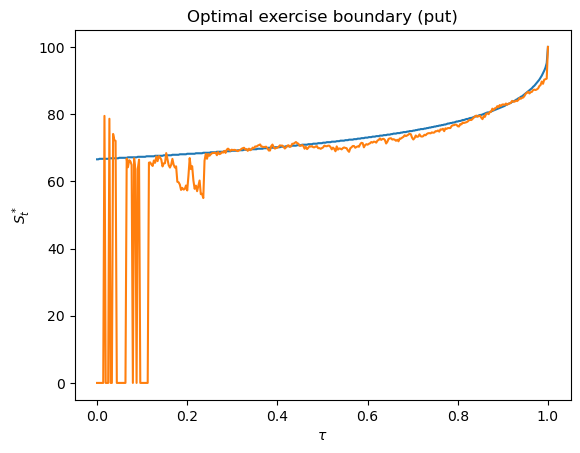

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 45.442283 seconds
American price: 12.180098


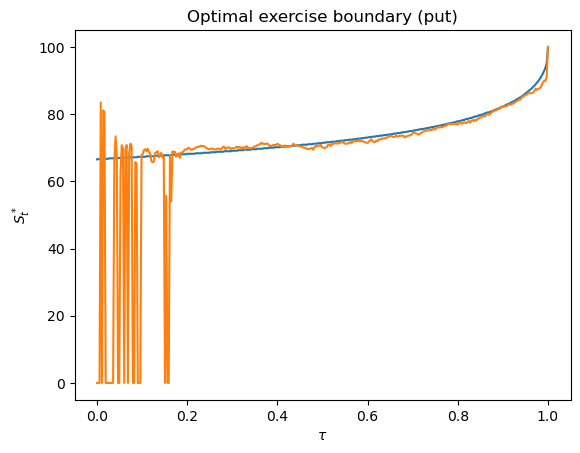

Type of Polynomial:  Chebychev_secondKind
Number of basis: 6
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 9.990256 seconds
American price: 12.320515


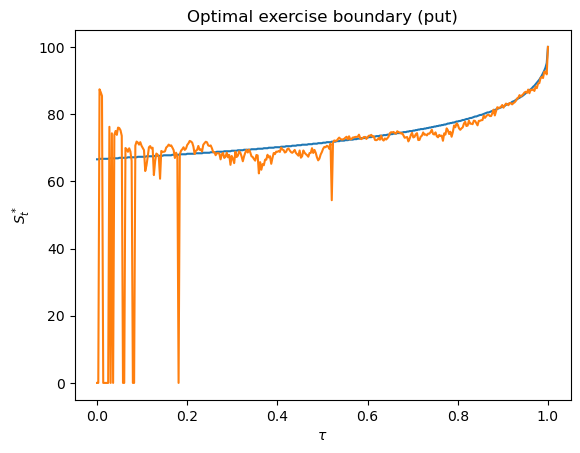

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 23.716144 seconds
American price: 12.122092


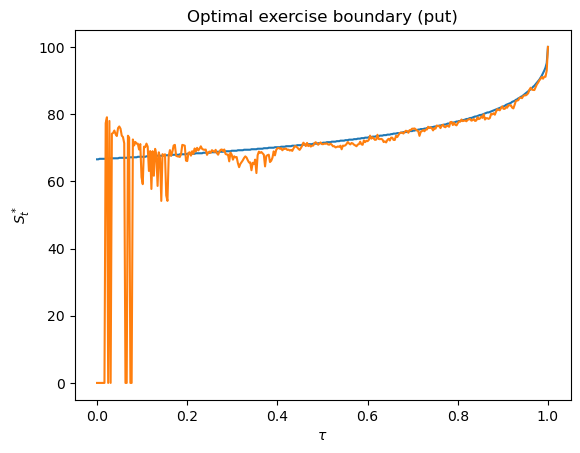

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 47.388428 seconds
American price: 12.195298


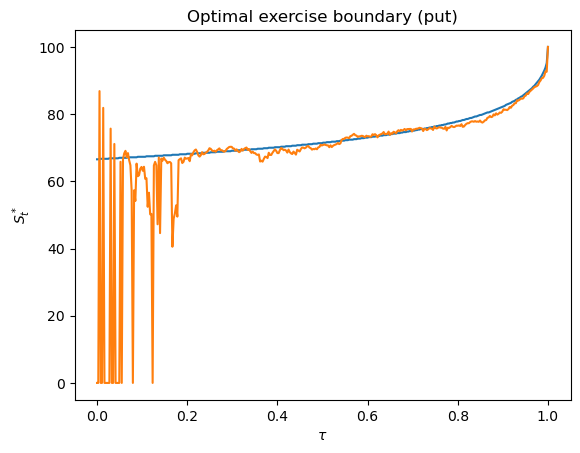

Type of Polynomial:  Chebychev_secondKind
Number of basis: 7
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 10.382693 seconds
American price: 12.189944


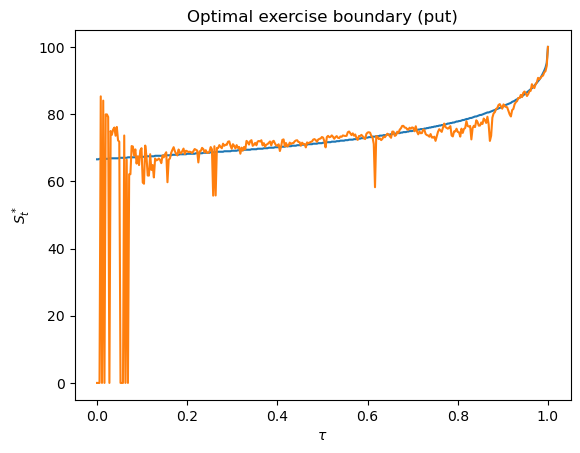

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 23.303685 seconds
American price: 12.260597


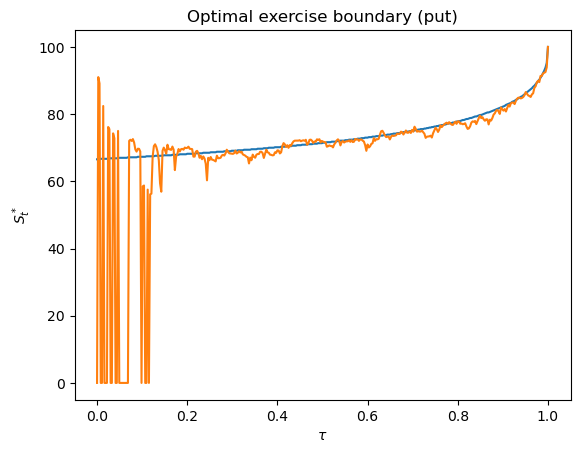

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 43.949943 seconds
American price: 12.229930


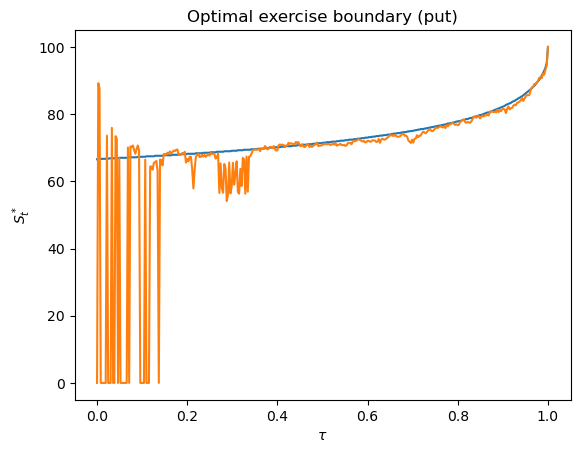

b
Type of Polynomial:  Laguerre
Number of basis: 4
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 8.054675 seconds
American price: 12.168843


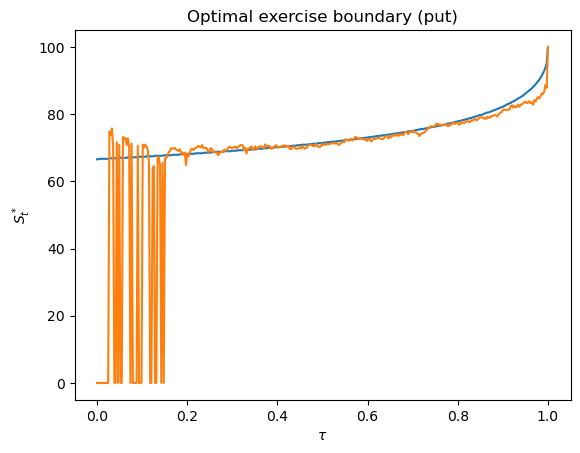

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 17.993029 seconds
American price: 12.146716


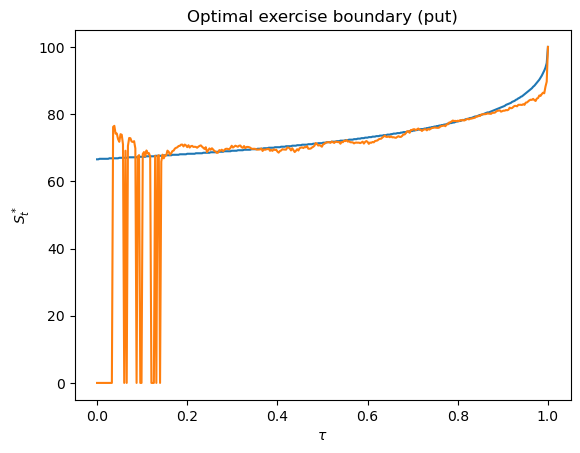

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 44.412683 seconds
American price: 12.277384


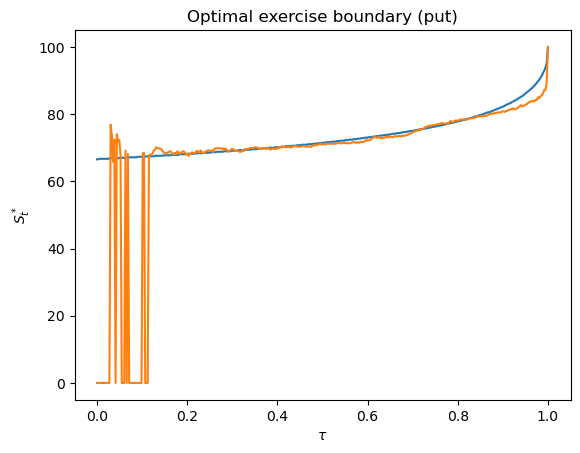

Type of Polynomial:  Laguerre
Number of basis: 5
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 8.905796 seconds
American price: 12.173156


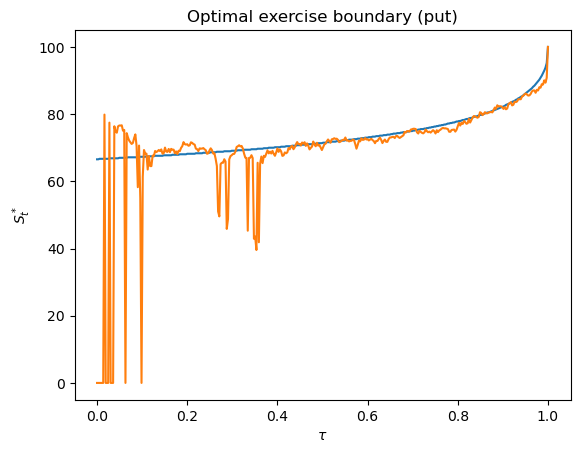

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 17.045191 seconds
American price: 12.156982


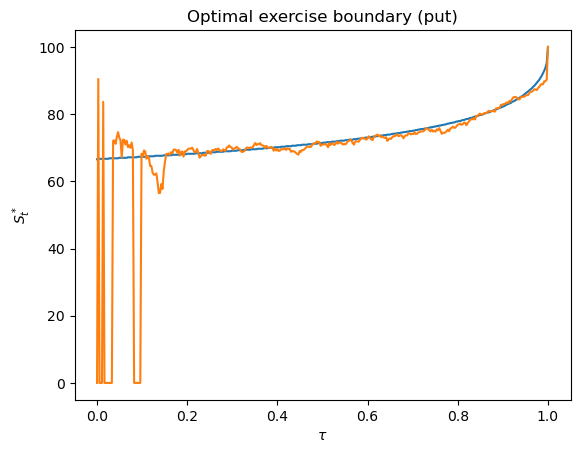

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 36.788830 seconds
American price: 12.177269


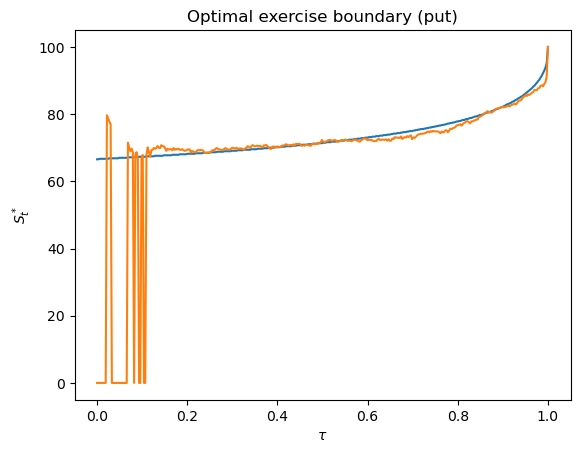

Type of Polynomial:  Laguerre
Number of basis: 6
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 10.031056 seconds
American price: 12.288767


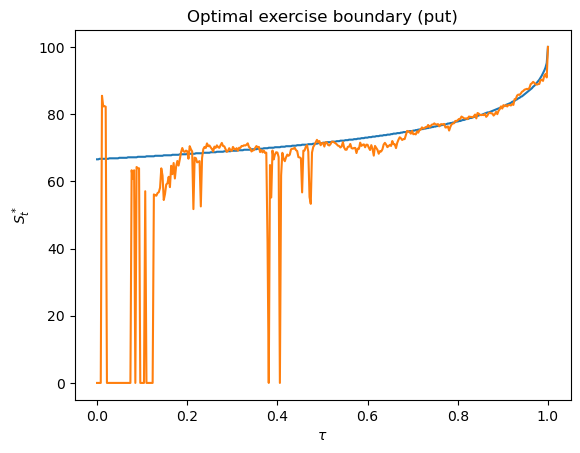

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 19.895082 seconds
American price: 12.152434


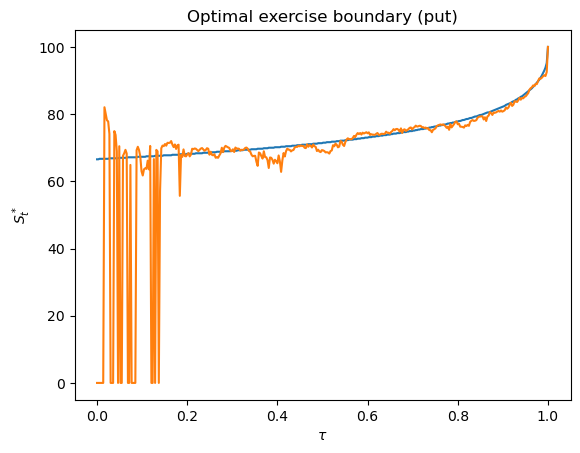

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 49.993107 seconds
American price: 12.161857


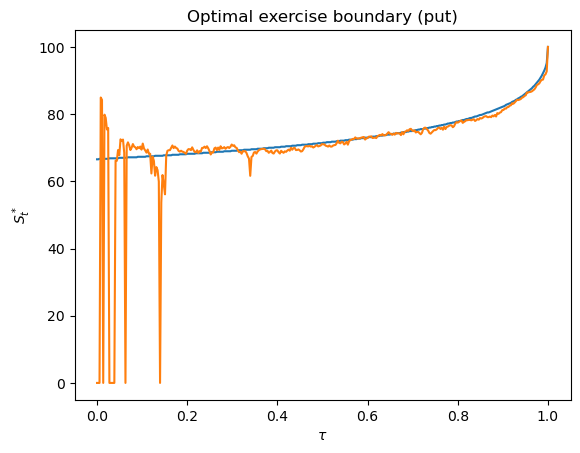

Type of Polynomial:  Laguerre
Number of basis: 7
------------------------------------------------------------
Number of sims: 50000
Elapsed times was 11.006579 seconds
American price: 12.163894


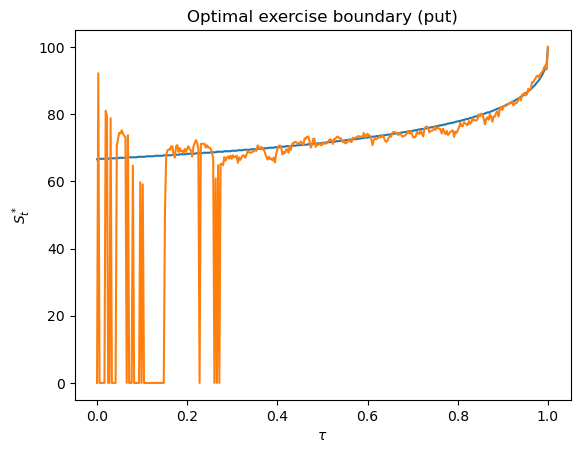

------------------------------------------------------------
Number of sims: 100000
Elapsed times was 22.035840 seconds
American price: 12.192952


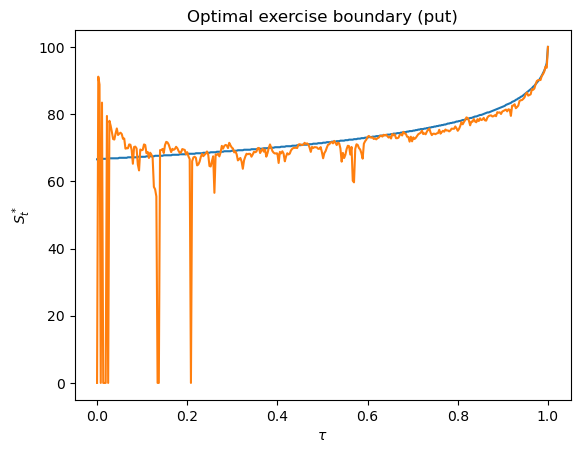

------------------------------------------------------------
Number of sims: 200000
Elapsed times was 57.972869 seconds
American price: 12.180138


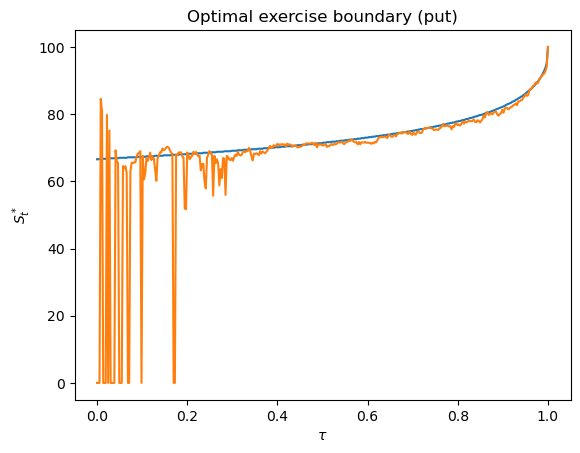

In [17]:
nb_of_basis = [4,5,6,7]
nb_of_paths = [50000,100000,200000]
list_typeOfPolynomial = ['Chebychev_firstKind','Chebychev_secondKind','Laguerre']

polynomial_pricing(nb_of_basis, nb_of_paths,list_typeOfPolynomial)

The results indicate that there is no significant difference in performance among the various methods. Furthermore, increasing the number of simulations does not appear to offer substantial gains in precision, as nsims=50,000 provides results very close to the actual price. Nevertheless, based on the trend of the data and the obtained outcomes, the 4th and 5th orders appear to be the most appropriate. A higher number of simulations aids in reducing the impact of minor or major fluctuations, hence improving accuracy. Additionally, for t > 0.4, it is evident that the interpolation is almost perfect for 6th and 7th order polynomials, with an improvement in accuracy as nsims increases for most polynomial forms employed.